In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from time import sleep
import numpy as np
import re

Define a function that scrapes the service:

In [2]:
def scrape_prisjakt(k):
    url = 'https://www.prisjakt.nu/kategori.php?k=' + str(k)
    page = requests.get(url)
    page_html = page.text
    total_amount_list = re.findall('"total":"(.*?)"',page_html)
    total_amount_string = total_amount_list[0]
    N = int(total_amount_string)

    #There are 50 products per page. Loop over pages.
    #Loop
    base_url = 'https://www.prisjakt.nu/kategori.php?k=' + str(k) + '&s='
    #Temporary N
    #N = 500
    df2 = []
    #Loop works
    for i in range (0,N+1,50):
        if i == 0:
            parameters = ''
        else:
            parameters = i
        r = requests.get(base_url, params = parameters)
        soup = BeautifulSoup(page.content, 'html.parser')
        sleep(20)
        print(i)

        #Get product list
        product_list = soup.find(id = 'div_produktlista')
        product_list

        #Call each product "item"
        items = product_list.find_all(class_ = 'drg-sidebar')

        #Collect product id, price and rating for each of 50 products on the page
        for product in range(0,50):
            #Get Product
            item = items[product]
            #Get id
            id_string = item.attrs['id']
            ids = id_string.split('-')[1]
            #Get price
            price_string = item.find(class_ = 'price')
            #prices = price_string.contents
            try:
                prices_text = price_string.get_text()
                prices_str = prices_text.split(':')[0]
                prices = prices_str.replace('\xa0','')
            except:
                prices  = price_string 
            #Get rating
            #Some products have missing values. Record missing values as "None"
            try:
                rating_string = item.find(class_ = 'stars7')
                ratings = rating_string['alt'].split('/')[0]
            except TypeError:
                ratings = None
            new_df2 = pd.DataFrame({'id':ids,'price':prices, 'rating':ratings},index=[product+i])
            df2.append(new_df2)

    pdf2 = pd.concat(df2, axis=0, sort=False)

    pdf2[['price','rating']] = pdf2[['price','rating']].apply(pd.to_numeric, errors = 'ignore')
    pdf2['log_price'] = np.log(pdf2['price'])
    
    pdf2.dropna(inplace = True)
    
    # add a variable for the category
    pdf2['k'] = k
    pdf2['N'] = N
    
    return pdf2

Check for one product:

In [ ]:
a = scrape_prisjakt(552)

In [ ]:
a[['log_price','rating']].corr()

Visualize the relationship between log price and rating:

In [13]:
import seaborn as sns
%matplotlib inline

/Users/circ-psk/Library/Python/3.6/lib/python/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


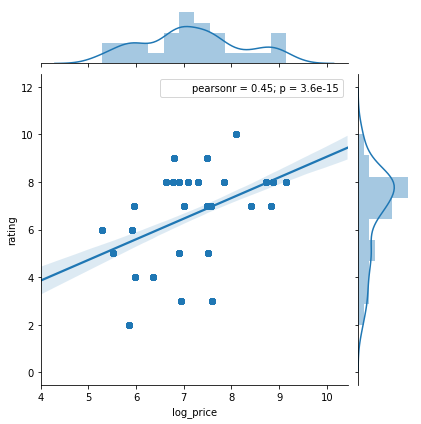

In [14]:
sns.jointplot(x='log_price',y='rating',data=pdf,kind='reg')

The correlation is indeed positive and strongly significant. It is, however, only 0.45 (on August 22nd). 

Run the analysis for a sample of products:

In [ ]:
from collections import OrderedDict
import random
from random import randrange

In [4]:
#Scrape product categories:
url_all = 'https://www.prisjakt.nu/'
page_all = requests.get(url_all)
page_html_all = page_all.text
all_products_list_long = re.findall('/kategori.php\?k=((?!v).*?)"',page_html_all)

In [5]:
#Drop irrelevant categories (they are longer than 4 symbols)
list_length = len(all_products_list_long)
for x in range(0,list_length):
    if len(all_products_list_long[x])>4:
        all_products_list_long[x] = '0'
        
#Remove duplicates        
all_products_list = list(OrderedDict.fromkeys(all_products_list_long))
all_products_list.remove('0')   
all_products_list

# pick a random sample
random_index = randrange(len(all_products_list))
random_sample = all_products_list[random_index:random_index+10]
random_sample

['1180', '1182', '1807', '1869', '1887', '1856', '1578', '480', '101', '326']

In [6]:
product_dfs = []

for k in random_sample:
    try:
        df = scrape_prisjakt(k)
        product_dfs.append(df)
    except:
        print("problem with",k)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450
500
550
600
0
50
100
150
200
250
300
0
50
100
150
200
250
300
350
400
450
500
0
50
0
problem with 1578
0
problem with 480
0
50
100
150
200
250
300
350
400
450
500
550
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000


In [7]:
df_all=pd.concat(product_dfs)

In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2868 entries, 0 to 2047
Data columns (total 6 columns):
id           2868 non-null object
price        2868 non-null float64
rating       2868 non-null float64
log_price    2868 non-null float64
k            2868 non-null object
N            2868 non-null int64
dtypes: float64(3), int64(1), object(2)
memory usage: 156.8+ KB


In [10]:
df_all.groupby('k')[['log_price','rating']].corr().iloc[0::2,-1]

k              
101   log_price   -0.110363
1180  log_price   -0.136928
1182  log_price   -0.012568
1807  log_price    0.219723
1869  log_price    0.012755
1887  log_price    0.648627
326   log_price    0.158372
Name: rating, dtype: float64